In [1]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import keras
from keras import layers
import keras_tuner



In [2]:
def read_data(type, folder, length):
    df = pd.DataFrame()
    parameters = pd.read_csv('Simulation_'+type+'/parameters_v1.txt')
    for i in range(length):
        new_data = pd.read_csv('Simulation_'+type+'/'+folder+'/'+type+'_X_data.csv/'+type+'_'+str(i+1)+'_data.csv')
        mean_force = new_data['FKN'].mean()
        max_force = new_data['FKN'].max()
        new_data_df = pd.DataFrame()
        new_data_df['mean_force'] = [mean_force]
        new_data_df['max_force'] = [max_force]
        for parameter in parameters.columns:
            new_data_df[parameter] = parameters[parameter][i]
        df = pd.concat([df, new_data_df])
    df = df.drop(columns=['sample'])
    df.reset_index(drop=True, inplace=True)

    return df

df = read_data(type='CRUSHING', folder='CONSTANT_THICKNESS_100', length=100)
df.head()

,mean_force,max_force,outer_wall_thickness,inside_wall_side_thickness,inside_wall_middle_thickness,height,width,sigma0,youngs
0,116.183099,187.578344,2.50,2.15,1.63,75.95,127.83,263.44,66771.2
1,125.198705,202.560469,2.83,2.02,1.44,75.76,127.25,246.66,69501.7
2,117.235652,205.683984,2.85,1.78,1.44,76.51,127.53,243.62,65759.5
3,113.854128,190.665063,2.71,1.72,1.51,75.41,127.61,258.13,65259.4
4,115.093363,191.023219,2.67,1.74,1.65,76.22,128.53,261.38,65053.8


In [3]:
X = df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
#Y = df[['max_force', 'mean_force']]
Y = df[['max_force']].values

In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [5]:
SVR_model =SVR(kernel='rbf',C=100,gamma= 0.1)
SVR_model.fit(X_train,Y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=100, gamma=0.1)

In [6]:
KRG_model = KRG(theta0=[1e-2], corr='squar_exp')
KRG_model.set_training_values(X_train, Y_train)
KRG_model.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.7994428


In [7]:
d0_values = np.linspace(10, 1000, 100)
print(d0_values)
results = {}
for i in range(len(d0_values)):
    RBF_model = RBF(d0=d0_values[i])
    RBF_model.set_training_values(X_train, Y_train)
    RBF_model.train()
    Y_pred = RBF_model.predict_values(X_val)
    mse = mean_squared_error(Y_val, Y_pred)
    results[d0_values[i]] = mse

[  10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.  120.
  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.  240.
  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.  360.
  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.  480.
  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.  600.
  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.  720.
  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.  840.
  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.  960.
  970.  980.  990. 1000.]
___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing li

{10.0: 24.237784542506063, 20.0: 18.824496583203207, 30.0: 14.121517633034827, 40.0: 13.705966180313917, 50.0: 14.20112425197577, 60.0: 14.380449030433407, 70.0: 14.405290243493136, 80.0: 14.365758220968672, 90.0: 14.284794830712276, 100.0: 14.16627308575066, 110.0: 14.009313202839483, 120.0: 13.81267995416161, 130.0: 13.57669203654604, 140.0: 13.303811864005748, 150.0: 12.998992367923119, 160.0: 12.669700193075577, 170.0: 12.324569810601716, 180.0: 11.973422732598355, 190.0: 11.625648694688728, 200.0: 11.289762533575828, 210.0: 10.972461318832094, 220.0: 10.678571300863213, 230.0: 10.410798370593222, 240.0: 10.170368724348762, 250.0: 9.957101443043111, 260.0: 9.769692777608608, 270.0: 9.606228663370052, 280.0: 9.464595502807379, 290.0: 9.342597548306212, 300.0: 9.23818291684444, 310.0: 9.148898361561555, 320.0: 9.07306710046317, 330.0: 9.009067569828698, 340.0: 8.95532910081457, 350.0: 8.910638991039912, 360.0: 8.87379868744669, 370.0: 8.843770201825178, 380.0: 8.819609751662904, 390.

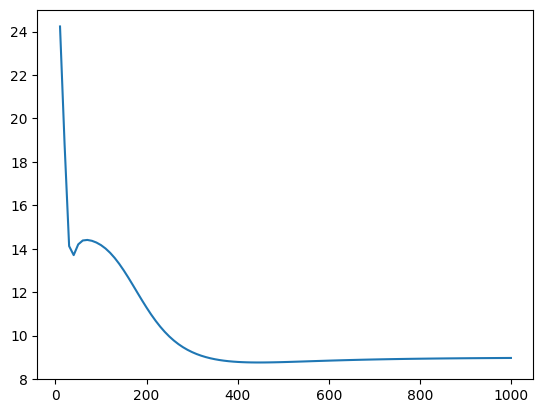

In [8]:
print(results)
plt.plot(results.keys(), results.values())
print(min(results, key=results.get))

In [9]:
RBF_model = RBF(d0=min(results, key=results.get), print_global=False)
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()
Y_pred = RBF_model.predict_values(X_val)

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],)))
    model.add(layers.Dropout(rate=0.2))
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=480, step=64), 
            activation=hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid']),
            ))
        #model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(
        units=1, 
        activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model

hp = keras_tuner.HyperParameters()
build_model(hp)

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective='mse',
    max_trials=1000,
    executions_per_trial=1,
    directory='keras_tuner',
    project_name='test_1'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(
    X_train, 
    Y_train, 
    epochs=500,
    batch_size=32,
    validation_data=(X_val, Y_val), 
    callbacks=[early_stopping]
    )

In [ ]:
models = tuner.get_best_models(num_models=5)
best_model = models[0]
best_model.summary()

In [ ]:
tuner.results_summary()

In [30]:
#   1. Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

#   2. Compile the model
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mse']
)

#   3. Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

#    4. Train the model
history = model.fit(
    X_train,
    Y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/500
3/3 [==============================] - 0s 33ms/step - loss: 42244.2812 - mse: 42244.2812 - val_loss: 41043.5742 - val_mse: 41043.5742
Epoch 2/500
3/3 [==============================] - 0s 7ms/step - loss: 42147.0195 - mse: 42147.0195 - val_loss: 40930.7031 - val_mse: 40930.7031
Epoch 3/500
3/3 [==============================] - 0s 7ms/step - loss: 42006.9570 - mse: 42006.9570 - val_loss: 40721.5977 - val_mse: 40721.5977
Epoch 4/500
3/3 [==============================] - 0s 7ms/step - loss: 41747.8828 - mse: 41747.8828 - val_loss: 40334.2109 - val_mse: 40334.2109
Epoch 5/500
3/3 [==============================] - 0s 7ms/step - loss: 41269.0938 - mse: 41269.0938 - val_loss: 39635.2188 - val_mse: 39635.2188
Epoch 6/500
3/3 [==============================] - 0s 7ms/step - loss: 40416.0430 - mse: 40416.0430 - val_loss: 38396.2305 - val_mse: 38396.2305
Epoch 7/500
3/3 [==============================] - 0s 7ms/step - loss: 38886.7109 - mse: 38886.7109 - val_loss: 36264.0430 - val_

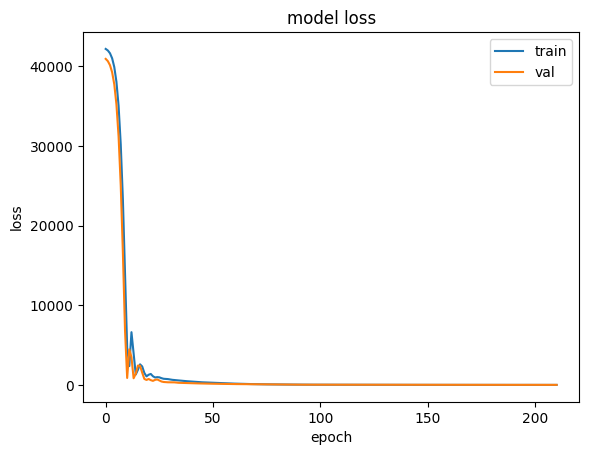

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [16]:
Y_predicted_KRG = KRG_model.predict_values(X_val)
Y_predicted_RBF = RBF_model.predict_values(X_val)
Y_predicted_SVR = SVR_model.predict(X_val)
Y_predicted_ANN = model.predict(X_val)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0069509
   
   Prediction time/pt. (sec) :  0.0003475
   
1/1 [==============================] - 0s 39ms/step


In [17]:
print("MSE, for KRG:", mean_squared_error(Y_val, Y_predicted_KRG))
print("MSE, for RBF:", mean_squared_error(Y_val, Y_predicted_RBF))
print("MSE, for SVR:", mean_squared_error(Y_val, Y_predicted_SVR))
print("MSE, for ANN:", mean_squared_error(Y_val, Y_predicted_ANN))

MSE, for KRG: 15.665873407916061
MSE, for RBF: 8.760798869819766
MSE, for SVR: 10.317877896018562
MSE, for ANN: 9.42345938981651


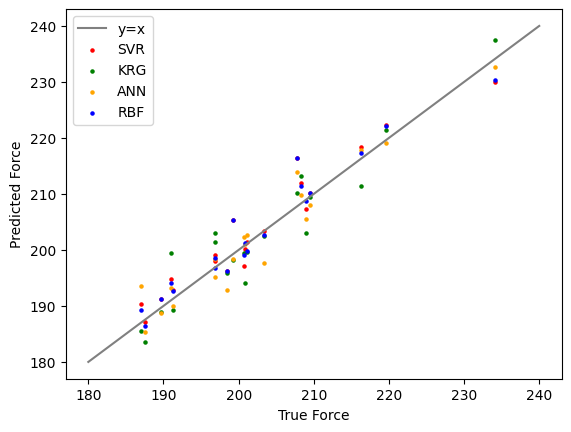

In [18]:
plt.plot([180, 240], [180, 240], label='y=x', color='gray')

plt.scatter(Y_val,Y_predicted_SVR, s=5, label= 'SVR', color='red')
plt.scatter(Y_val, Y_predicted_KRG, s=5, label='KRG', color='green')
plt.scatter(Y_val, Y_predicted_ANN, s=5, label='ANN', color='orange')
plt.scatter(Y_val, Y_predicted_RBF, s=5, label='RBF', color='blue')

plt.xlabel('True Force')
plt.ylabel('Predicted Force')
plt.legend()